In [1]:
import re
import time

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import requests
import urllib3
from bs4 import BeautifulSoup
from pandas import DataFrame, Series
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

%matplotlib inline

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)


In [2]:
# SUUMOからデータを取得


def get_suumo():
    # URL（ここにURLを入れてください）
    url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13122&cb=0.0&ct=9999999&mb=0&mt=9999999&et=9999999&cn=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=09'

    result = requests.get(url)
    c = result.content

    soup = BeautifulSoup(c)

    summary = soup.find("div", {'id': 'js-bukkenList'})
    body = soup.find("body")
    pages = body.find_all("div", {'class': 'pagination pagination_set-nav'})
    pages_text = str(pages)
    pages_split = pages_text.split('</a></li>\n</ol>')
    pages_split0 = pages_split[0]
    pages_split1 = pages_split0[-3:]
    pages_split2 = pages_split1.replace('>', '')
    pages_split3 = int(pages_split2)

    urls = []

    urls.append(url)

    for i in range(pages_split3-1):
        pg = str(i+2)
        url_page = url + '&page=' + pg
        urls.append(url_page)

    names = []
    addresses = []
    locations0 = []
    locations1 = []
    locations2 = []
    ages = []
    heights = []
    floors = []
    rent = []
    admin = []
    others = []
    floor_plans = []
    areas = []
    detail_urls = []

    for url in urls:
        result = requests.get(url)
        c = result.content
        soup = BeautifulSoup(c)
        summary = soup.find("div", {'id': 'js-bukkenList'})
        apartments = summary.find_all("div", {'class': 'cassetteitem'})

        for apartment in apartments:

            room_number = len(apartment.find_all('tbody'))

            name = apartment.find(
                'div', class_='cassetteitem_content-title').text
            address = apartment.find(
                'li', class_='cassetteitem_detail-col1').text

            for i in range(room_number):
                names.append(name)
                addresses.append(address)

            sublocation = apartment.find(
                'li', class_='cassetteitem_detail-col2')
            cols = sublocation.find_all('div')
            for i in range(len(cols)):
                text = cols[i].find(text=True)
                for j in range(room_number):
                    if i == 0:
                        locations0.append(text)
                    elif i == 1:
                        locations1.append(text)
                    elif i == 2:
                        locations2.append(text)

            age_and_height = apartment.find(
                'li', class_='cassetteitem_detail-col3')
            age = age_and_height('div')[0].text
            height = age_and_height('div')[1].text

            for i in range(room_number):
                ages.append(age)
                heights.append(height)

            table = apartment.find('table')
            # rows = []
            # rows.append(table.find_all('tr'))

            data = []
            # for row in rows:
            # for tr in row:
            for tr in table.find_all('tr'):
                cols = tr.find_all('td')
                if len(cols) != 0:
                    _floor = cols[2].text
                    _floor = re.sub('[\r\n\t]', '', _floor)

                    _rent_cell = cols[3].find('ul').find_all('li')
                    _rent = _rent_cell[0].find('span').text
                    _admin = _rent_cell[1].find('span').text

                    _deposit_cell = cols[4].find('ul').find_all('li')
                    _deposit = _deposit_cell[0].find('span').text
                    _reikin = _deposit_cell[1].find('span').text
                    _others = _deposit + '/' + _reikin

                    _floor_cell = cols[5].find('ul').find_all('li')
                    _floor_plan = _floor_cell[0].find('span').text
                    _area = _floor_cell[1].find('span').text

                    _detail_url = cols[8].find('a')['href']
                    _detail_url = 'https://suumo.jp' + _detail_url

                    text = [_floor, _rent, _admin, _others,
                            _floor_plan, _area, _detail_url]
                    data.append(text)

            for row in data:
                floors.append(row[0])
                rent.append(row[1])
                admin.append(row[2])
                others.append(row[3])
                floor_plans.append(row[4])
                areas.append(row[5])
                detail_urls.append(row[6])

            time.sleep(3)

    names = Series(names)
    addresses = Series(addresses)
    locations0 = Series(locations0)
    locations1 = Series(locations1)
    locations2 = Series(locations2)
    ages = Series(ages)
    heights = Series(heights)
    floors = Series(floors)
    rent = Series(rent)
    admin = Series(admin)
    others = Series(others)
    floor_plans = Series(floor_plans)
    areas = Series(areas)
    detail_urls = Series(detail_urls)

    suumo_df = pd.concat([names, addresses, locations0, locations1, locations2, ages,
                          heights, floors, rent, admin, others, floor_plans, areas, detail_urls], axis=1)

    suumo_df.columns = ['マンション名', '住所', '立地1', '立地2', '立地3', '築年数',
                        '建物の高さ', '階層', '賃料', '管理費', '敷/礼/保証/敷引,償却', '間取り', '専有面積', '詳細URL']

    suumo_df.to_csv('suumo.csv', sep='\t', encoding='utf-16',
                    header=True, index=False)



In [3]:
# get_suumo()


In [4]:
df = pd.read_csv('suumo.csv', sep='\t', encoding='utf-16')


In [5]:
df.head(3)


,マンション名,住所,立地1,立地2,立地3,築年数,建物の高さ,階層,賃料,管理費,"敷/礼/保証/敷引,償却",間取り,専有面積,詳細URL
0,若松荘,東京都葛飾区高砂８,京成本線/京成高砂駅 歩5分,京成金町線/柴又駅 歩10分,北総線/新柴又駅 歩13分,築48年,2階建,2階,3.8万円,-,-/-,1K,16m2,https://suumo.jp/chintai/jnc_000058129026/?bc=...
1,レジデンスカープ新小岩,東京都葛飾区東新小岩５,ＪＲ総武線/新小岩駅 歩9分,ＪＲ総武線快速/新小岩駅 歩9分,京成押上線/京成立石駅 歩32分,築41年,5階建,2階,4万円,2500円,4万円/-,ワンルーム,13.6m2,https://suumo.jp/chintai/jnc_000046727008/?bc=...
2,レジデンスカープ新小岩,東京都葛飾区東新小岩５,ＪＲ総武線/新小岩駅 歩9分,ＪＲ総武線快速/新小岩駅 歩9分,京成押上線/京成立石駅 歩32分,築41年,5階建,3階,4万円,2500円,8万円/-,ワンルーム,11.4m2,https://suumo.jp/chintai/jnc_000057824906/?bc=...


In [6]:
# データ前処理1


def data_preprocessing1(df):
    splitted1 = df['立地1'].str.split(' 歩', expand=True)
    splitted1.columns = ['立地11', '立地12']
    splitted2 = df['立地2'].str.split(' 歩', expand=True)
    splitted2.columns = ['立地21', '立地22']
    splitted3 = df['立地3'].str.split(' 歩', expand=True)
    splitted3.columns = ['立地31', '立地32']

    splitted4 = df['敷/礼/保証/敷引,償却'].str.split('/', expand=True)
    splitted4.columns = ['敷金', '礼金']

    df = pd.concat([df, splitted1, splitted2, splitted3, splitted4], axis=1)

    df.drop(['立地1', '立地2', '立地3', '敷/礼/保証/敷引,償却'], axis=1, inplace=True)

    df = df.dropna(subset=['賃料'])

    df['賃料'] = df['賃料'].str.replace(u'万円', u'')
    df['敷金'] = df['敷金'].str.replace(u'万円', u'')
    df['礼金'] = df['礼金'].str.replace(u'万円', u'')
    df['管理費'] = df['管理費'].str.replace(u'円', u'')
    df['築年数'] = df['築年数'].str.replace(u'新築', u'0')
    df['築年数'] = df['築年数'].str.replace(u'99年以上', u'0')
    df['築年数'] = df['築年数'].str.replace(u'築', u'')
    df['築年数'] = df['築年数'].str.replace(u'年', u'')
    df['専有面積'] = df['専有面積'].str.replace(u'm', u'')
    df['立地12'] = df['立地12'].str.replace(u'分', u'')
    df['立地22'] = df['立地22'].str.replace(u'分', u'')
    df['立地32'] = df['立地32'].str.replace(u'分', u'')

    df['管理費'] = df['管理費'].replace('-', 0)
    df['敷金'] = df['敷金'].replace('-', 0)
    df['礼金'] = df['礼金'].replace('-', 0)

    splitted5 = df['立地11'].str.split('/', expand=True)
    splitted5.columns = ['路線1', '駅1']
    splitted5['徒歩1'] = df['立地12']
    splitted6 = df['立地21'].str.split('/', expand=True)
    splitted6.columns = ['路線2', '駅2']
    splitted6['徒歩2'] = df['立地22']
    splitted7 = df['立地31'].str.split('/', expand=True)
    splitted7.columns = ['路線3', '駅3']
    splitted7['徒歩3'] = df['立地32']

    df = pd.concat([df, splitted5, splitted6, splitted7], axis=1)

    df.drop(['立地11', '立地12', '立地21', '立地22', '立地31', '立地32'],
            axis=1, inplace=True)

    df['賃料'] = pd.to_numeric(df['賃料'])
    df['管理費'] = pd.to_numeric(df['管理費'])
    df['敷金'] = pd.to_numeric(df['敷金'])
    df['礼金'] = pd.to_numeric(df['礼金'])
    df['築年数'] = pd.to_numeric(df['築年数'])
    df['専有面積'] = pd.to_numeric(df['専有面積'])

    df['賃料'] = df['賃料'] * 10000
    df['敷金'] = df['敷金'] * 10000
    df['礼金'] = df['礼金'] * 10000

    df['徒歩1'] = pd.to_numeric(df['徒歩1'])
    df['徒歩2'] = pd.to_numeric(df['徒歩2'])
    df['徒歩3'] = pd.to_numeric(df['徒歩3'])

    splitted8 = df['階層'].str.split('-', expand=True)
    splitted8.columns = ['階1', '階2']
    splitted8['階1'].str.encode('cp932')
    splitted8['階1'] = splitted8['階1'].str.replace(u'階', u'')
    splitted8['階1'] = splitted8['階1'].str.replace(u'B', u'-')
    splitted8['階1'] = splitted8['階1'].str.replace(u'M', u'')
    splitted8['階1'] = pd.to_numeric(splitted8['階1'])
    df = pd.concat([df, splitted8], axis=1)

    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下1地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下2地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下3地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下4地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下5地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下6地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下7地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下8地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'地下9地上', u'')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'平屋', u'1')
    df['建物の高さ'] = df['建物の高さ'].str.replace(u'階建', u'')
    df['建物の高さ'] = pd.to_numeric(df['建物の高さ'])

    df = df.reset_index(drop=True)
    df['間取りDK'] = 0
    df['間取りK'] = 0
    df['間取りL'] = 0
    df['間取りS'] = 0
    df['間取り'] = df['間取り'].str.replace(u'ワンルーム', u'1')

    for x in range(len(df)):
        if 'DK' in df['間取り'][x]:
            df.loc[x, '間取りDK'] = 1
    df['間取り'] = df['間取り'].str.replace(u'DK', u'')

    for x in range(len(df)):
        if 'K' in df['間取り'][x]:
            df.loc[x, '間取りK'] = 1
    df['間取り'] = df['間取り'].str.replace(u'K', u'')

    for x in range(len(df)):
        if 'L' in df['間取り'][x]:
            df.loc[x, '間取りL'] = 1
    df['間取り'] = df['間取り'].str.replace(u'L', u'')

    for x in range(len(df)):
        if 'S' in df['間取り'][x]:
            df.loc[x, '間取りS'] = 1
    df['間取り'] = df['間取り'].str.replace(u'S', u'')

    df['間取り'] = pd.to_numeric(df['間取り'])

    splitted9 = df['住所'].str.split('区', expand=True)
    splitted9.columns = ['区', '市町村']
    splitted9['区'] = splitted9['区'] + '区'
    splitted9['区'] = splitted9['区'].str.replace('東京都', '')
    df = pd.concat([df, splitted9], axis=1)

    df['賃料+管理費'] = df['賃料'] + df['管理費']

    return df



In [7]:
df = data_preprocessing1(df)
df_for_search = df.copy()


In [8]:
df.head(3)


,マンション名,住所,築年数,建物の高さ,階層,賃料,管理費,間取り,専有面積,詳細URL,敷金,礼金,路線1,駅1,徒歩1,路線2,駅2,徒歩2,路線3,駅3,徒歩3,階1,階2,間取りDK,間取りK,間取りL,間取りS,区,市町村,賃料+管理費
0,若松荘,東京都葛飾区高砂８,48,2,2階,38000.0,0,1,162.00,https://suumo.jp/chintai/jnc_000058129026/?bc=...,0.0,0.0,京成本線,京成高砂駅,5,京成金町線,柴又駅,10.0,北総線,新柴又駅,13.0,2.0,None,0,1,0,0,葛飾区,高砂８,38000.0
1,レジデンスカープ新小岩,東京都葛飾区東新小岩５,41,5,2階,40000.0,2500,1,13.62,https://suumo.jp/chintai/jnc_000046727008/?bc=...,40000.0,0.0,ＪＲ総武線,新小岩駅,9,ＪＲ総武線快速,新小岩駅,9.0,京成押上線,京成立石駅,32.0,2.0,None,0,0,0,0,葛飾区,東新小岩５,42500.0
2,レジデンスカープ新小岩,東京都葛飾区東新小岩５,41,5,3階,40000.0,2500,1,11.42,https://suumo.jp/chintai/jnc_000057824906/?bc=...,80000.0,0.0,ＪＲ総武線,新小岩駅,9,ＪＲ総武線快速,新小岩駅,9.0,京成押上線,京成立石駅,32.0,3.0,None,0,0,0,0,葛飾区,東新小岩５,42500.0


In [9]:
# データ前処理2


def data_preprocessing2(df):
    df[['路線1', '路線2', '路線3', '駅1', '駅2', '駅3', '市町村']] = df[[
        '路線1', '路線2', '路線3', '駅1', '駅2', '駅3', '市町村']].fillna("NAN")

    oe = preprocessing.OrdinalEncoder()
    df[['路線1', '路線2', '路線3', '駅1', '駅2', '駅3', '市町村']] = oe.fit_transform(
        df[['路線1', '路線2', '路線3', '駅1', '駅2', '駅3', '市町村']].values)

    # 上限価格を設定
    # df = df[df['賃料+管理費'] < 300000]

    df = df[["マンション名", '賃料+管理費', '築年数', '建物の高さ', '階1',
             '専有面積', '路線1', '路線2', '路線3', '駅1', '駅2', '駅3', '徒歩1', '徒歩2', '徒歩3', '間取り', '間取りDK', '間取りK', '間取りL', '間取りS',
             '市町村']]

    df.columns = ['name', 'real_rent', 'age', 'height', 'level', 'area', 'route_1', 'route_2', 'route_3', 'station_1',
                  'station_2', 'station_3', 'distance_1', 'distance_2', 'distance_3', 'room_number', 'DK', 'K', 'L', 'S', 'adress']

    return df



In [10]:
df = data_preprocessing2(df)


In [11]:
df.head(3)


,name,real_rent,age,height,level,area,route_1,route_2,route_3,station_1,station_2,station_3,distance_1,distance_2,distance_3,room_number,DK,K,L,S,adress
0,若松荘,38000.0,48,2,2.0,162.00,3.0,5.0,9.0,15.0,130.0,131.0,5,10.0,13.0,1,0,1,0,0,149.0
1,レジデンスカープ新小岩,42500.0,41,5,2.0,13.62,10.0,20.0,6.0,23.0,113.0,40.0,9,9.0,32.0,1,0,0,0,0,61.0
2,レジデンスカープ新小岩,42500.0,41,5,3.0,11.42,10.0,20.0,6.0,23.0,113.0,40.0,9,9.0,32.0,1,0,0,0,0,61.0


In [12]:
# データ全体の情報
# pdp.ProfileReport(df)


In [13]:
# 特徴量作成
df["per_area"] = df["area"] / df["room_number"]
df["height_level"] = df["height"] * df["level"]
df["area_height_level"] = df["area"] * df["height_level"]
df["distance_staion_1"] = df["station_1"] * df["distance_1"]


0.79219496001907


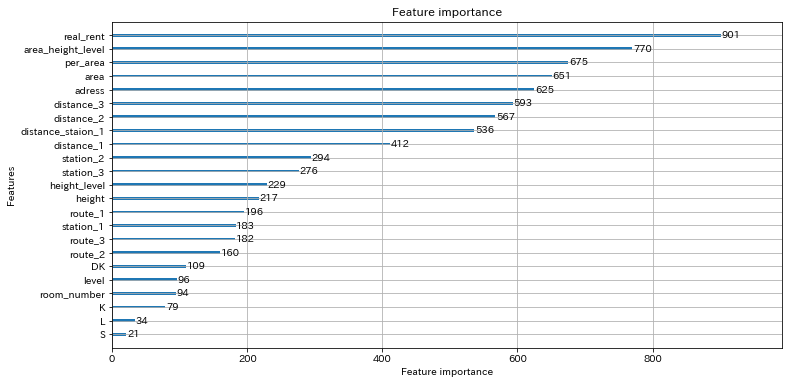

In [14]:
# 機械学習
y = df["age"]
X = df.drop(['age', "name"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 80
}

model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, verbose_eval=-1)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print(r2_score(y_test, y_pred))
lgb.plot_importance(model, figsize=(12, 6))
plt.show()


In [15]:
pred = list(model.predict(X, num_iteration=model.best_iteration))
pred = pd.Series(pred, name="予測値")
diff = pd.Series(df["age"]-pred, name="予測値との差")
df_search = pd.concat([df_for_search, diff, pred], axis=1)


In [16]:
df_age = df_search[['マンション名', '築年数',  '予測値',  '予測値との差', '賃料+管理費', '詳細URL']]
df_age = df_age.sort_values("予測値との差")
df_age = df_age.reset_index(drop=True)
df_age.to_csv('age_otoku.csv', sep='\t', encoding='utf-16')


In [17]:
df_age = pd.read_csv('age_otoku.csv', sep='\t', encoding='utf-16')


In [18]:
df_age.head(3)


,Unnamed: 0,マンション名,築年数,予測値,予測値との差,賃料+管理費,詳細URL
0,0,Maison Neko,4,38.474855,-34.474855,85000.0,https://suumo.jp/chintai/jnc_000058051225/?bc=...
1,1,プランドール新小岩,8,40.327145,-32.327145,74000.0,https://suumo.jp/chintai/jnc_000058226432/?bc=...
2,2,MaisonNeko,4,35.325601,-31.325601,84000.0,https://suumo.jp/chintai/jnc_000026921806/?bc=...


In [19]:


def rank_plot(df_age, border):
    # 上位20位を表示
    num = 20

    y1 = df_age['築年数'][:num]
    y2 = df_age['予測値'][:num]
    y3 = -df_age['予測値との差'][:num]

    x = np.arange(num)

    w = 0.4

    plt.figure(figsize=(10, 6))

    plt.bar(x, y1, color='blue', width=w, label='実測値', align='center')
    plt.bar(x+w, y2, color='lightblue', width=w, label='予測値', align='center')
    plt.plot(x, y3, color='red', linewidth=5, label='予測値との差')

    plt.xticks(x+w/2, x)
    plt.ylabel('築年数(年)')

    plt.title("{}年以下(上位{}件)".format(border, num))
    plt.legend(loc='best')

    plt.grid(True)


In [20]:


def per_plot(df_age, border):
    # 100件毎に表示
    step = 100

    y1 = df_age.loc[::step, '築年数']
    y2 = df_age.loc[::step, '予測値']
    y3 = -df_age.loc[::step, '予測値との差']

    x = np.arange(0, len(df_age.index), step)

    w = 40

    plt.figure(figsize=(10, 6))

    plt.bar(x, y1, color='blue', width=w, label='実測値', align='center')
    plt.bar(x+w, y2, color='lightblue', width=w, label='予測値', align='center')
    plt.plot(x, y3, color='red', linewidth=5, label='予測値との差')

    plt.xticks((x+w/2)[::border//10], x[::border//10])
    plt.ylabel('築年数(年)')

    plt.title("{}年以下({}件毎)".format(border, step))
    plt.legend(loc='best')

    plt.grid(True)



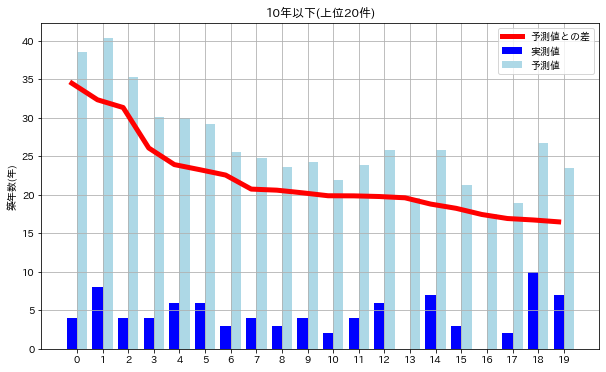

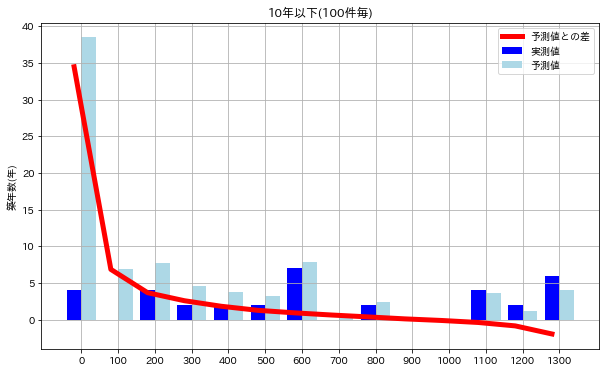

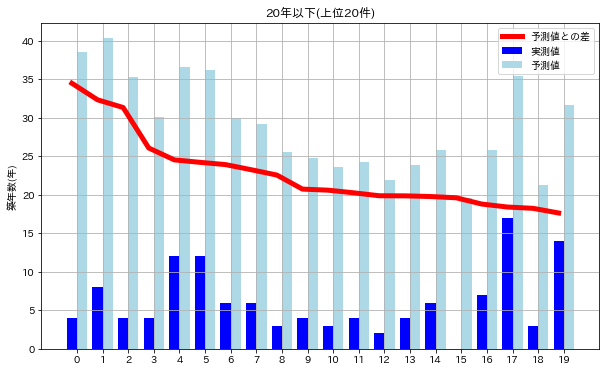

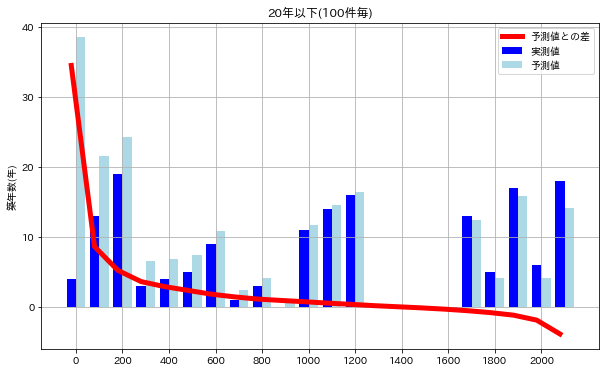

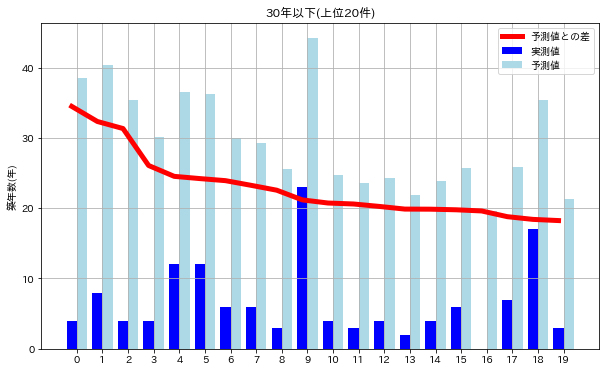

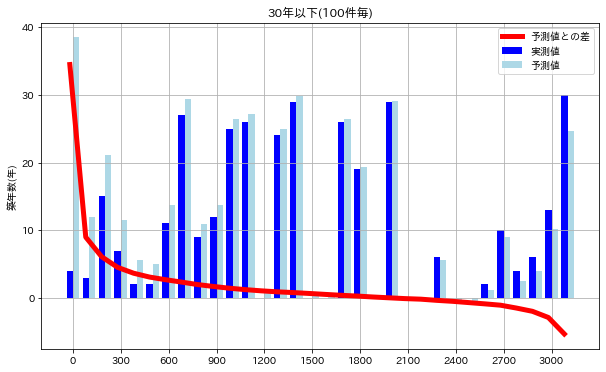

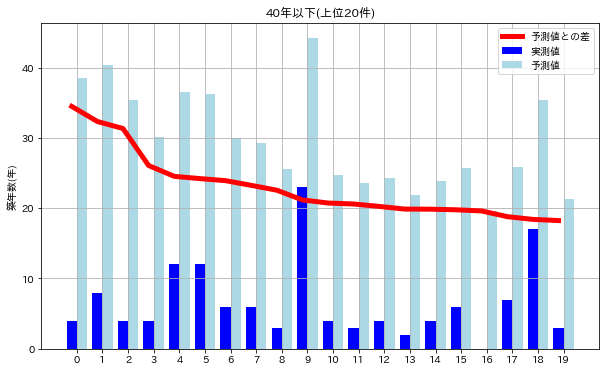

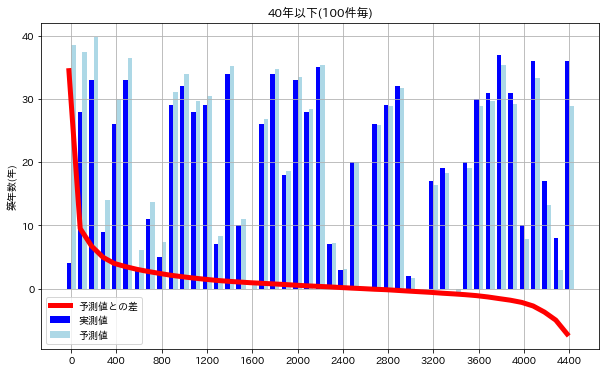

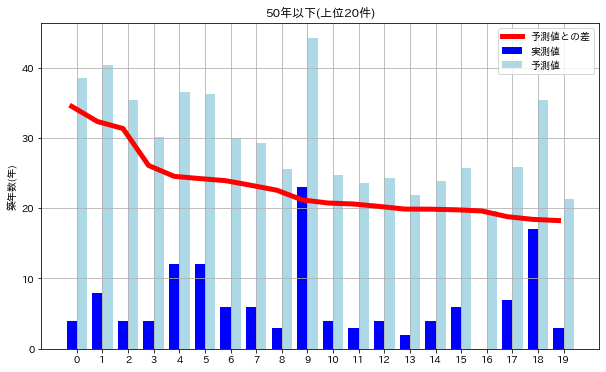

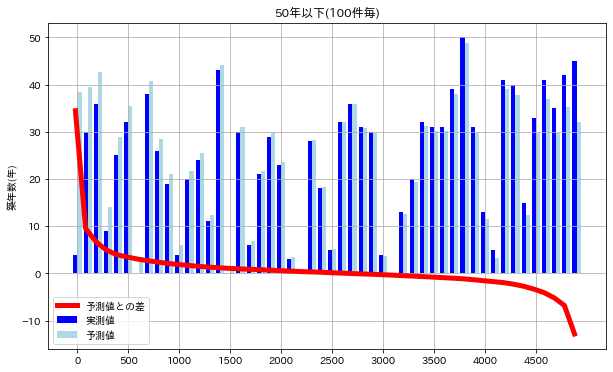

In [21]:
borders = [10, 20, 30, 40, 50]
for border in borders:
    rank_plot(df_age[df_age['築年数'] <= border], border)
    per_plot(df_age[df_age['築年数'] <= border], border)
